# Homework 2 ATED - Group 1

In [1]:
%pylab inline
import math
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import quad
import sympy as sp
import fmt
plt.style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


## HW2-1

##### (a) Estimate the market price of the $5\%$ call spread (i.e. with strikes ATM and $5\%$ OTM). What about the $5\%$ put spread?

In [2]:
# Market prices
MarketCS = 478.1-337.1
MarketPS = 428.3-326.1

print("5% call spread:", MarketCS)
print("5% put spread", MarketPS)

5% call spread: 141.0
5% put spread 102.19999999999999


##### (b) If you were to price the spreads in the Black-Scholes model using a single volatility parameter $\sigma$, what value of $\sigma$ would match the theoretical price with the market price? Comment on your results.

In [3]:
# Elementary functions
dN = lambda x: math.exp(-0.5*x**2)/math.sqrt(2*math.pi)
N = lambda d: quad(lambda x:dN(x),-20,d,limit=50)[0]
d1 = lambda sigma,St,K,t,T,r: (math.log(St/K)+(r+0.5*sigma**2)*(T-t))/(sigma*math.sqrt(T-t))
d2 = lambda sigma,St,K,t,T,r: d1(sigma,St,K,t,T,r) - sigma * sqrt(T-t)

# B-S call price
BSCall = lambda sigma,St,K,t,T,r: St * N(d1(sigma,St,K,t,T,r)) - K * exp(-r*(T-t)) * N(d2(sigma,St,K,t,T,r))
BSPut = lambda sigma,St,K,t,T,r: K * exp(-r*(T-t)) * N(-d2(sigma,St,K,t,T,r)) - St * N(-d1(sigma,St,K,t,T,r))

In [4]:
# Parameters
St = 5448
K = 5450
K95 = 5200
K105 = 5750
t = 0
T = 1
r = 0.0125

# CS B-S price
BSCS = lambda sigma: BSCall(sigma,St,K95,t,T,r) - BSCall(sigma,St,K,t,T,r)
BSCSvol = lambda sigma: BSCall(sigma,St,K95,t,T,r) - BSCall(sigma,St,K,t,T,r) - MarketCS
BSPSVol = lambda sigma: BSPut(sigma,St,K105,t,T,r) - BSPut(sigma,St,K,t,T,r) - MarketPS

In [5]:
# Implied vols
sigmaCS = optimize.root(BSCSvol, x0=[0.01])
sigmaPS = optimize.root(BSPSVol, x0=[0.01])
print(sigmaCS.x, sigmaPS.x)

[0.14133943] [0.17103521]


We find an "implied volatility" of about 14.13% for the call spread and 17.10% for the put spread, which is in the range of volatility observed for put and call option until 5% OTM.

## HW2-2

##### (a) Using the numerical package of your choice, calibrate the parameters of the SVI model against the market-implied volatility data. Show a comparative graph of the SVI curve and the actual implied volatility data points.

In [6]:
# Auxiliary function to read percentages
p2f = lambda x: float(x.strip('%'))/100
toY = lambda x: float(x)/349

# Read spot indicators
spotIndicators = (pd.read_csv("HW2_data.csv",nrows=4,usecols=[0,1],header=None)).T
spotIndicators.columns = spotIndicators.iloc[0]
spotIndicators = spotIndicators.reindex(spotIndicators.index.drop(0))

# Parameters
NDX = float(spotIndicators.iloc[0,0])
r = p2f(spotIndicators.iloc[0,1])
f = float(spotIndicators.iloc[0,2])
T = toY(spotIndicators.iloc[0,3])

# Read options data
optionsData = pd.read_csv("HW2_data.csv",skiprows=5, nrows=54, usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
CK, CB, CA, CM = (optionsData.iloc[:,0]).astype(float), (optionsData.iloc[:,2]).astype(float), (optionsData.iloc[:,3]).astype(float), (optionsData.iloc[:,4]).astype(float)
CIV = [p2f(x) for x in optionsData.iloc[:,5]]
PK, PB, PA, PM = (optionsData.iloc[:,6]).astype(float), (optionsData.iloc[:,8]).astype(float), (optionsData.iloc[:,9]).astype(float), (optionsData.iloc[:,10]).astype(float)
PIV = [p2f(x) for x in optionsData.iloc[:,11]]

In [7]:
# SVI vol expression
impliedVolSVImodel = lambda a,b,rho,m,s,k : np.sqrt(a + b * (rho * (log(k/f) - m) + np.sqrt((log(k/f)-m)**2 + s**2)))

# Residual sum of squares of the regression
def RSS(params): a,b,rho,m,s = params; return(np.sum([(impliedVolSVImodel(a,b,rho,m,s,k)**2 - CIV[i]**2)**2 + (impliedVolSVImodel(a,b,rho,m,s,k)**2 - PIV[i]**2)**2 for i,k in enumerate(CK)]))

In [8]:
# Initial values and constraints
startPoint = [0.009,0.11,0.5,0.2,0.05]
eps = 0.0001
boundsSet = ((0+eps, None), (0+eps, None),(-1+eps, 1-eps),(None,None),(0+eps,None))

# No arbitrage
constraintsSet = ({'type': 'ineq', 'fun': lambda x:  x[1] * (1 + abs(x[2])) - 4})

# Calibration
result = optimize.minimize(fun=RSS, x0=startPoint, method='SLSQP', bounds=boundsSet, constraints=constraintsSet, options={'disp': False})
if result.success: fitted_params = result.x; print(fitted_params)
else: raise ValueError(result.message)

[3.63891908e-04 2.54545815e+00 9.61104282e-01 2.39034320e-01
 1.48721402e-02]


In [9]:
# Moneyness
moneyness = np.array(CK/f)

# Model fitted parameters
a, b, rho, m, s = result.x

# SVI curve
sviSmile = [impliedVolSVImodel(a,b,rho,m,s,f*x) for x in moneyness]

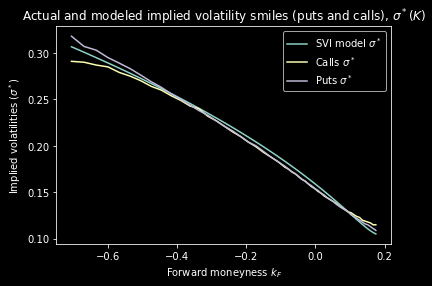

In [10]:
# Superposition
plt.plot(log(moneyness),sviSmile,label="SVI model $\sigma^*$")
plt.plot(log(moneyness),CIV,label="Calls $\sigma^*$")
plt.plot(log(moneyness),PIV,label="Puts $\sigma^*$")
plt.xlabel('Forward moneyness $k_F$')
plt.ylabel(r'Implied volatilities $(\sigma^*)$')
plt.title('Actual and modeled implied volatility smiles (puts and calls), $\sigma^*(K)$')
plt.legend()
plt.show()

##### (b) Compute or estimate the price of an at-the-money digital call option paying off $\$1$ if in one year NDX is greater than its current spot level, and zero otherwise: (i) in the Black-Scholes model, (ii) using $\pm 1\%$ call spreads, (iii) using the smile-adjusted formula on page 19.

In [11]:
# Black-scholes model
BSDig = lambda sigma,St,K,t,T,r: math.exp(-r*(T-t)) * N(d2(sigma,St,K,t,T,r))

# Price
BSDigprice = BSDig(0.1540,5048.,5050.,0.,1.,r)
print("Black-Scholes price:",BSDigprice)

Black-Scholes price: 0.4944179530921919


In [12]:
# With pm 1% call spreads
SellCallPlus1Percent = 308.2
BuyCallMinus1Percent = 350.1
StrikeDifference = 5500 - 5400

# Price
CSDigprice = (BuyCallMinus1Percent - SellCallPlus1Percent) / StrikeDifference
print("pm1% call spread price:",CSDigprice)

pm1% call spread price: 0.4190000000000003


In [33]:
# Black-Scholes vega
BSVega = lambda sigma,St,K,t,T,r: St * dN(d1(sigma,St,K,t,T,r)) * sqrt(T-t)

# Derivative of SVI using sympy
spImpliedVolSVImodel = lambda f,a,b,rho,m,s,k : sp.sqrt(a + b * (rho * (sp.log(k/f) - m) + sp.sqrt((sp.log(k/f)-m)**2 + s**2)))
SPf, SPa, SPb, SPrho, SPm, SPs, SPk = sp.Symbol('f'), sp.Symbol('a'), sp.Symbol('b'), sp.Symbol('rho'), sp.Symbol('m'), sp.Symbol('s'), sp.Symbol('k')
derivKSIV = sp.diff(spImpliedVolSVImodel(SPf, SPa, SPb, SPrho, SPm, SPs, SPk),SPk)
print("Derivative of sigma wrt to K:")
fmt.displayMath(sp.latex(sp.S(derivKSIV,evaluate=False)))

# Smile-adjusted formula
def SADig(St,K,t,T,r):
    sigma = impliedVolSVImodel(a,b,rho,m,s,K)
    replacement = [(SPf,f),(SPa,a),(SPb,b),(SPrho,rho),(SPm,m),(SPs,s),(SPk,K)]
    return(BSDig(sigma,St,K,t,T,r) - BSVega(sigma,St,K,t,T,r) * derivKSIV.subs(replacement))

# Price
SADigPrice = SADig(5048,5050,0,1,r)
print("Smile adjusted price:",SADigPrice)

Derivative of sigma wrt to K:


<IPython.core.display.Math object>

Smile adjusted price: 0.589459411453675


##### (c) Graph the implied distribution corresponding to the SVI model calibration.

In [31]:
# Second derivative of sigma wrt to K
derivKSIV2 = sp.diff(derivKSIV,SPk)
print("Second derivative of sigma wrt to K:")
fmt.displayMath(sp.latex(sp.S(derivKSIV2,evaluate=False)))

Second derivative of sigma wrt to K:


<IPython.core.display.Math object>

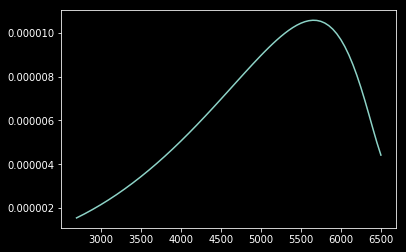

In [50]:
# SVI implied distribution for the stock price at maturity
def P(St,K):
    sigma = impliedVolSVImodel(a,b,rho,m,s,K)
    replacement = [(SPf,f),(SPa,a),(SPb,b),(SPrho,rho),(SPm,m),(SPs,s),(SPk,K)]
    firstDerivKSigma, secondDerivKSigma = derivKSIV.subs(replacement), derivKSIV2.subs(replacement)
    vald1, vald2 = d1(sigma,St,K,t,T,r), d2(sigma,St,K,t,T,r)
    return((dN(vald2) / K * sigma * sqrt(T)) * (1 + 2 * vald1 * (K * firstDerivKSigma * sqrt(T)) + vald1 * vald2 * (K * firstDerivKSigma * sqrt(T))**2 + (K * secondDerivKSigma * sqrt(T)) * (K * sigma * sqrt(T))))

strikes = CK.values
probabilities = [P(5448, s) for s in strikes]

plt.plot(strikes,probabilities);
plt.savefig("implied_distribution")

##### (d) Use the implied distribution to compute the price of the following European exotic options, where $X_0$ is the current index level and $X_T$ is the final index level:

##### i. Digital call defined in question (b);

In [ ]:
# TODO

##### ii. "Reverse convertible" paying off $\max\left(100\%, 100\% + p \times \frac{X_T- X_0}{X_0}\right)$ if $\frac{X_T}{X_0} > 75 \%$ and $\frac{X_T}{X_0}$ otherwise, where $p = 50\%$. Then solve for $p$ to get a price of $100\%$;

In [ ]:
# TODO

##### iii. Option paying off $\max\left(0, \frac{X_T- X_0}{X_T}\right)$;


In [ ]:
# TODO

##### iv. Log-contract paying off $-2\log\left(\frac{X_T}{X_0}\right)$. Price interpretation;

In [ ]:
# TODO

## HW2-3

#### Find conditions on the SVI model parameters to satisfy Lee’s asymptotic bounds on p. $22$: 
$$\sigma^{\star^2} (k_F,T) \leq \frac{\beta}{T} |\log{k_F}|,\, \beta \in [0,2]$$

In [ ]:
# TODO

## HW2-4

#### (Problem $4.3$ p$.\ 56$ in textbook, with corrections): Consider an underlying stock $S$ currently trading at $S_0 = 100$ which does not pay any dividend. Assume the local volatility function is $\sigma_{loc} (t, S) = \frac{0.1 - 0.15 \times \log\left(\frac{S}{S_0}\right)}{\sqrt{t}}$, and that interest rates are zero.

##### (a) Produce the graph of the local volatility surface for spots $0$ to $200$ and maturities $0$ to $5$ years.

In [ ]:
# TODO

##### (b) Write a Monte-Carlo algorithm to price the following $1$-year payoffs using $252$ time steps and e.g.\ $10,000$ paths:

##### i. "Capped quadratic" option: $\min\left(1,\frac{S_1^2}{S_0^2}\right)$;

In [ ]:
# TODO

##### ii. Asian at-the-money-call: $\max\left(0, \frac{S_{0.25} + S_{0.5} + S_{0.75} + S_1}{4 \times S_0} - 1\right)$;

In [ ]:
# TODO

##### iii. Barrier call: $\max(0, S_1 - S_0)$ if $S$ always traded above $80$ using $252$ daily observations, 0 otherwise;

In [ ]:
# TODO

## HW2-5

#### The payoff of a $1$-year at-the-money call on the geometric average return of two non-dividend paying stocks $X, Y$ is given as: $$ f(X_T,Y_T) = \max\left(0, \sqrt{\frac{X_T Y_T}{X_0 Y_0}} - 1\right)$$ where $T = 1$ year and $X_t, Y_t$ are the respective underlying spot prices of $X, Y$ at any time $t$.

##### (a) Derive analytical formulas for the call value at any time $0 \leq t \leq T$ in the Black-Scholes model with constant correlation $\rho$ (cf.\ Section $6-4$ in the textbook, to be covered during Session $5$.)

In [ ]:
# TODO

##### (b) Compute the value of the call using a $5\%$ interest rate, $20\%$ volatility for $X$, $30\%$ volatility for $Y$, and $\rho = 0.4$. Use finite differences to estimate the deltas, gammas and cross-gamma of the call.

In [ ]:
# TODO

##### (c) You purchased the call on a $\$10,000,000$ notional. What actions would you take to delta-hedge your position? What would then be your instant $P\&L$ in the matrix of scenarios. Generally, graph your instant $P\&L$ against percent changes $x, y$ in underlying stock prices.

In [ ]:
# TODO